# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
import lightgbm as lgb
from imblearn.over_sampling import ADASYN, SMOTE

In [2]:
#### Path management

In [3]:
base: str
if os.getcwd() == "/kaggle/working":
    base = "/kaggle"
else:
    base = os.path.join(os.getcwd())

def get_full_dir(sub_dir: str) -> str:
    return os.path.join(base, sub_dir)

# EDA

In [4]:
df_sample_submission = pd.read_csv(get_full_dir('input/playground-series-s3e10/sample_submission.csv'))
df_train = pd.read_csv(get_full_dir('input/playground-series-s3e10/train.csv'), index_col='id')
df_test = pd.read_csv(get_full_dir('input/playground-series-s3e10/test.csv'), index_col='id')

In [5]:
df_train.isna().sum()

Mean_Integrated         0
SD                      0
EK                      0
Skewness                0
Mean_DMSNR_Curve        0
SD_DMSNR_Curve          0
EK_DMSNR_Curve          0
Skewness_DMSNR_Curve    0
Class                   0
dtype: int64

##### No missing vlaues, we can proceed

In [6]:
df_sample_submission.head()

,id,Class
0,117564,0.5
1,117565,0.5
2,117566,0.5
3,117567,0.5
4,117568,0.5


##### We are predicting binary class for each id

In [7]:
df_train.head()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
id,,,,,,,,,
0,133.171875,59.716081,0.043133,-0.703383,54.917224,70.084438,0.749798,-0.649512,0
1,87.093750,36.257973,0.435469,2.266057,3.417224,21.865069,7.039330,52.686251,0
2,112.640625,39.818393,0.379639,0.922306,2.730769,15.689690,8.193471,85.649785,0
3,120.679688,45.918448,-0.098490,0.011775,2.696488,20.954662,8.183874,70.332899,0
4,134.070312,57.720107,-0.107772,-0.573335,1.107860,11.255051,16.107748,308.753765,0


##### All features and target are continuous and numerical.

In [8]:
df_train.describe()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
count,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000
mean,111.248300,46.713535,0.503498,1.886385,11.962921,26.190678,8.037488,93.881076,0.093285
std,24.906474,6.102941,1.127093,6.515466,26.719946,20.041937,3.840980,79.962110,0.290833
min,6.054688,24.783273,-1.730782,-1.791886,0.213211,7.370432,-2.597872,-1.976976,0.000000
25%,104.546875,43.443390,0.049761,-0.188956,2.090301,14.955405,6.742911,49.409136,0.000000
50%,116.664062,47.478932,0.186498,0.091720,2.808528,18.164924,8.442883,83.421375,0.000000
75%,126.296875,50.862718,0.395620,0.691613,4.122910,24.732218,10.003237,122.093290,0.000000
max,189.367188,93.602933,7.879628,65.385974,217.371238,109.890785,34.539844,1191.000837,1.000000


<function matplotlib.pyplot.show(close=None, block=None)>

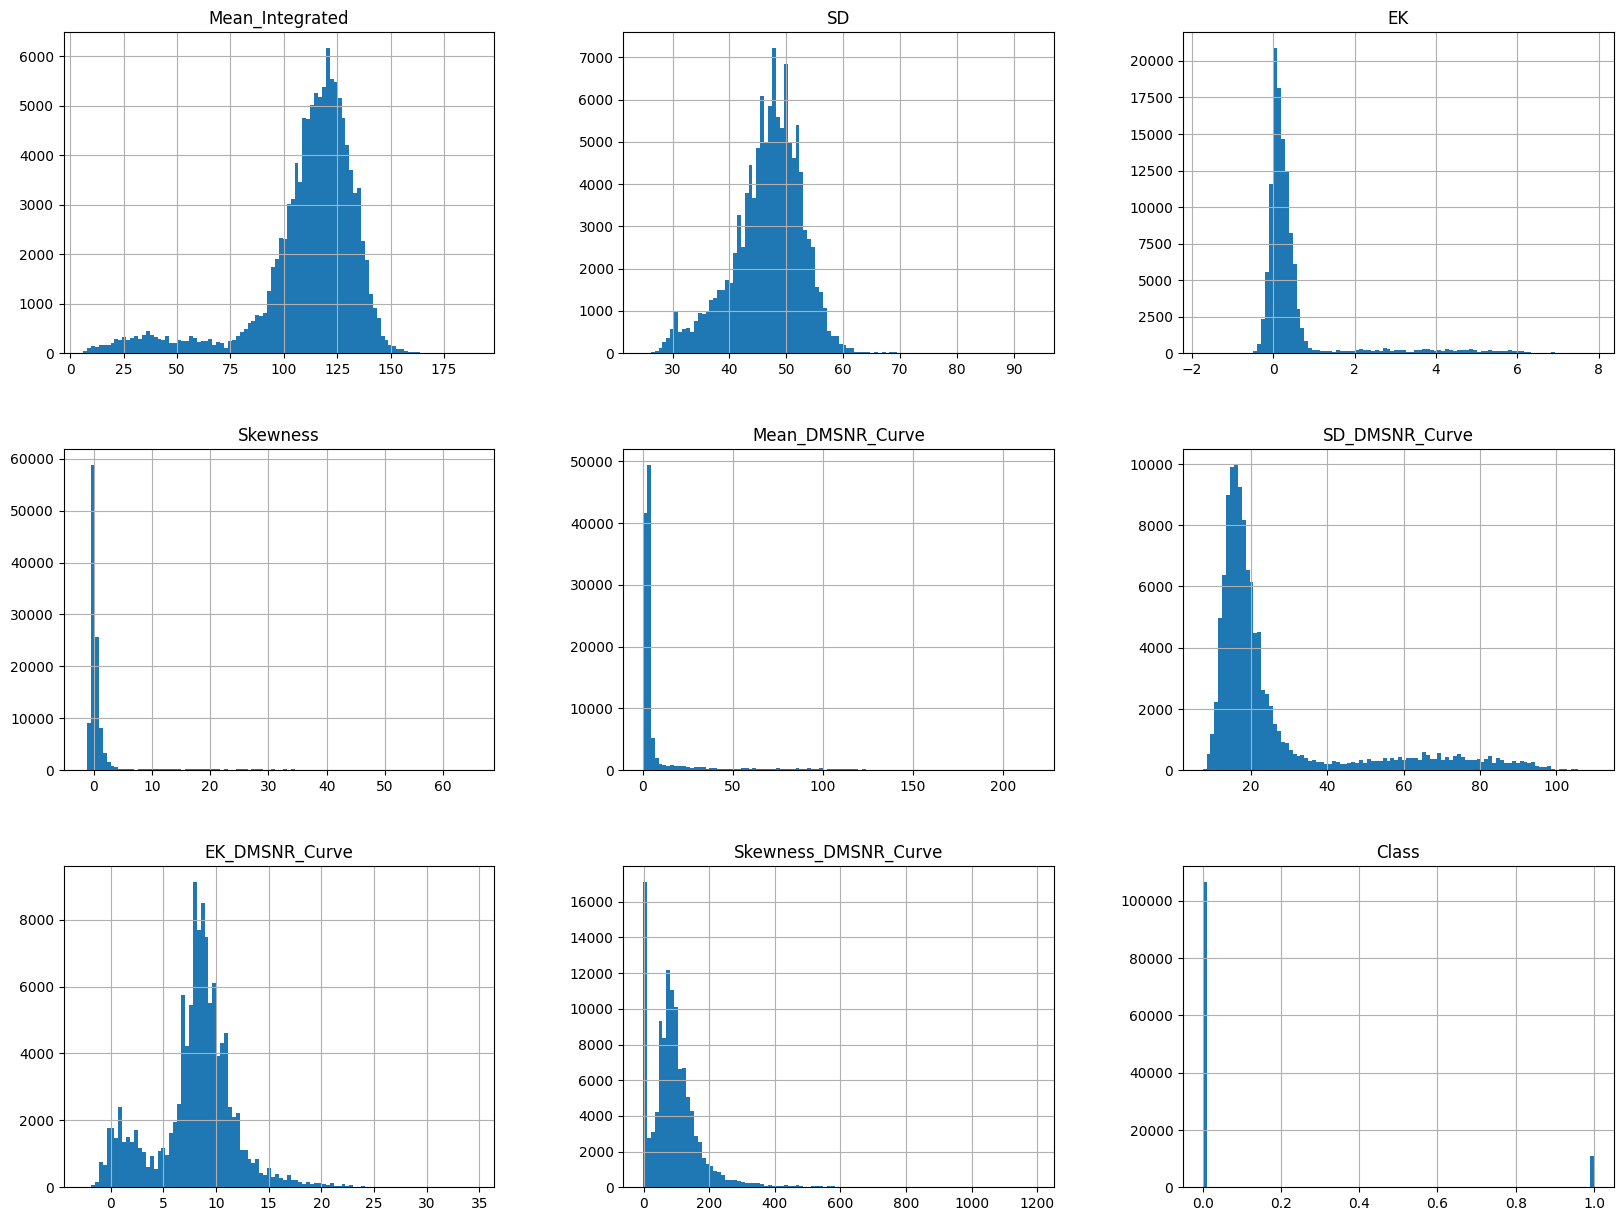

In [9]:
df_train.hist(bins=100, figsize=(20, 15))
plt.show

##### All features apper to have some outliers, there is also a large class inbalance

In [10]:
tmp = df_train["Class"].value_counts()
tmp

0    106597
1     10967
Name: Class, dtype: int64

In [11]:
n = (tmp[0] / (tmp[0] + tmp[1])) * 100
p = (tmp[1] / (tmp[0] + tmp[1])) * 100
print("Negative: %.3f%%, Positve: %.3f%%"% (n, p))

Negative: 90.671%, Positve: 9.329%


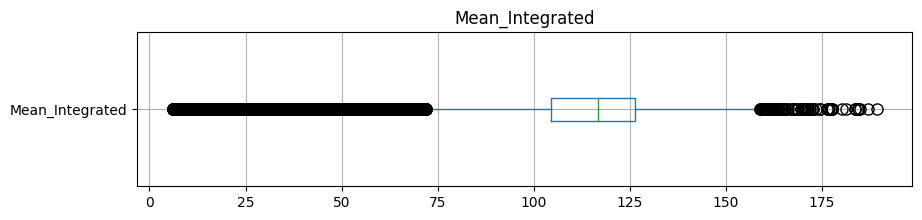

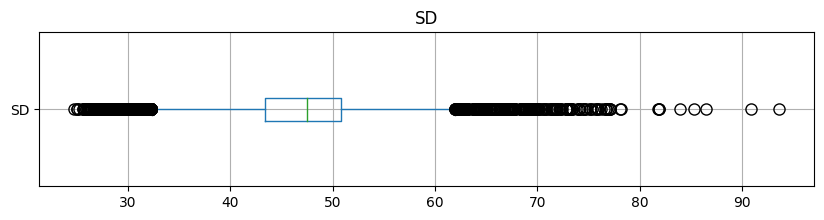

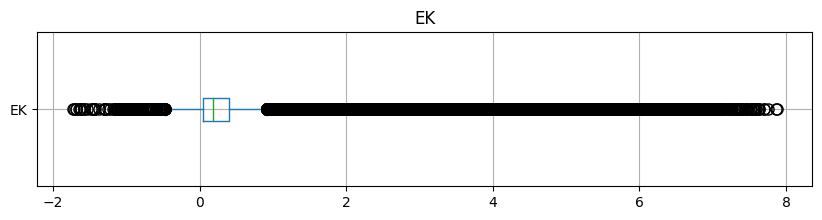

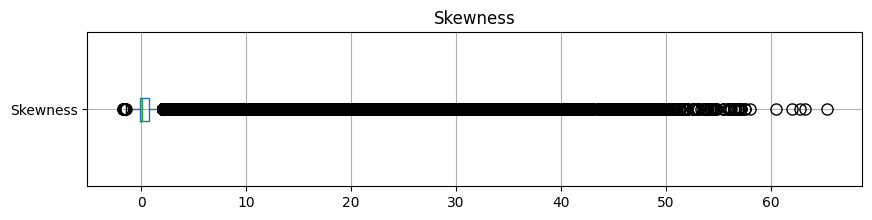

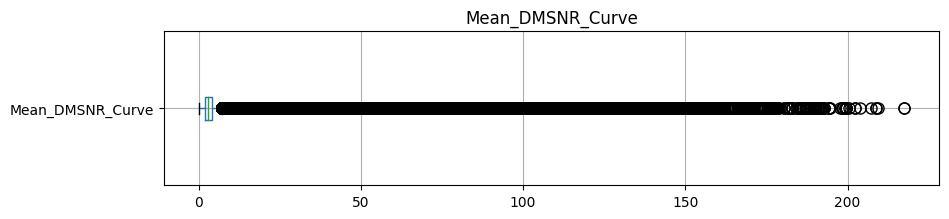

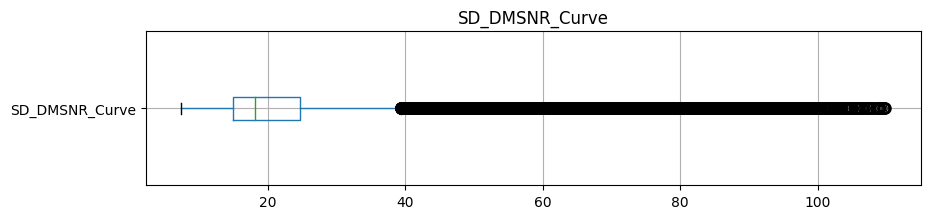

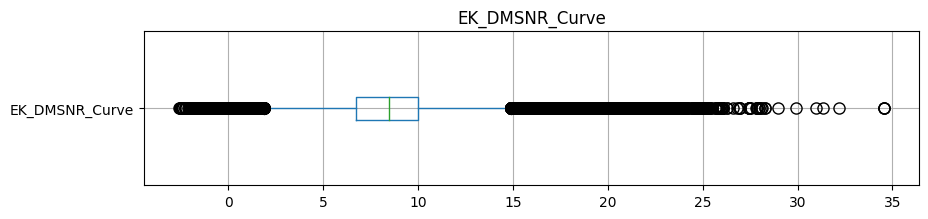

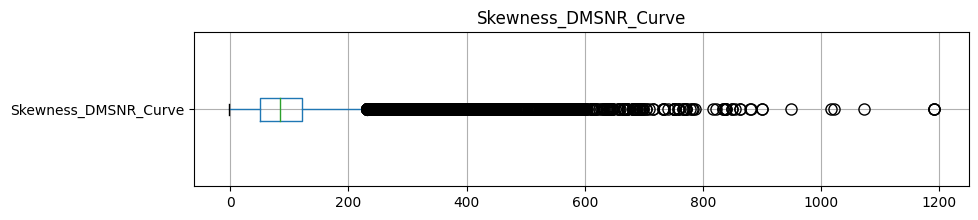

In [12]:
for col in df_train.columns:
    if col != "Class":
        fig = plt.figure(figsize=(10, 2))
        df_train.boxplot(column=[col], vert=False, flierprops=dict(marker='o', markersize=8))
        plt.title(col)
        plt.show()

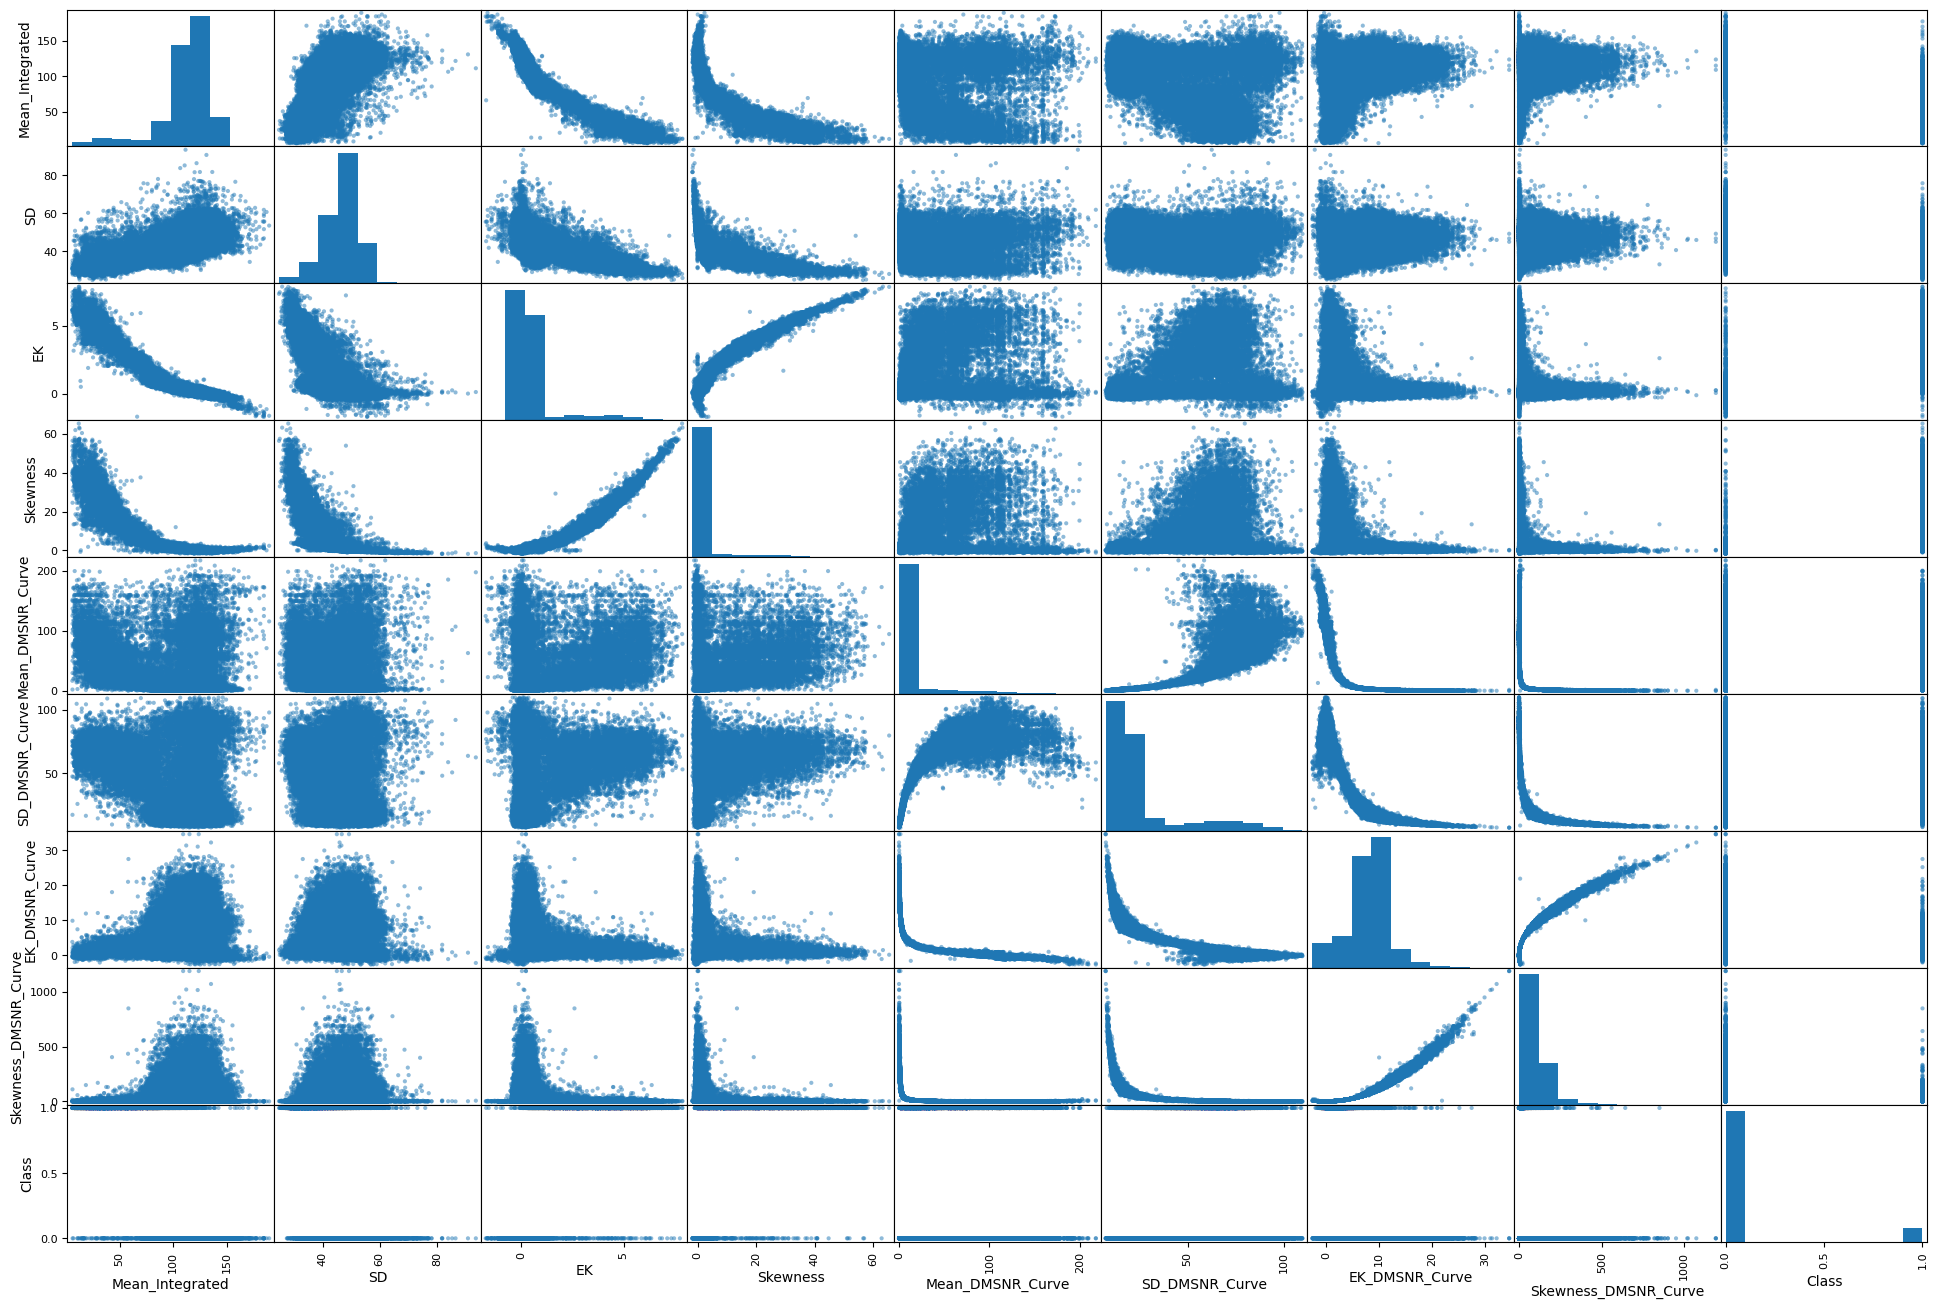

In [13]:
pd.plotting.scatter_matrix(df_train, figsize=(24, 16))
plt.show()

##### There are many corelation between featrues themselves, but on dicrect corelation with our target.

##### Prevent any unwanted changes made in EDA from leaking to training

In [14]:
df_train = pd.read_csv(get_full_dir('input/playground-series-s3e10/train.csv'), index_col='id')
df_test = pd.read_csv(get_full_dir('input/playground-series-s3e10/test.csv'), index_col='id')

# Address data impalance

In [15]:
oversample = False
    
if oversample:
    print(f"Before \t Total: {len(df_train)},\t Class 0: {df_train['Class'].value_counts()[0]},\t Class 1 { df_train['Class'].value_counts()[1]}")
    
    X = df_train.drop('Class', axis=1)
    y = df_train['Class']

    # Create the SMOTE object
    smote = SMOTE(sampling_strategy={1:106597}, random_state=42)
    # Fit and transform the data to generate oversampled data
    X_resampled, y_resampled = smote.fit_resample(X, y)
    X = X_resampled
    y = y_resampled
    df_train = pd.concat([X, pd.DataFrame(y)], axis=1)
    
    print(f"After \t Total: {len(df_train)},\t Class 0: {df_train['Class'].value_counts()[0]},\t Class 1 { df_train['Class'].value_counts()[1]}")

# Data Pipeline

In [16]:
class PulsarPipeline():
    
    def __init__(self, model='XGB', valid_sets=None):
        self.preprocessor = ColumnTransformer([ 
            ("num", StandardScaler(), df_train.drop('Class', axis=1).columns.tolist()), 
        ])
        
        self.model_type = model
        
        if model == 'LGB':
            self.model = lgb.LGBMClassifier(
                                            num_leaves = 16,
                                            learning_rate = 0.01,
                                            early_stopping_rounds = 100,
                                            n_estimators=2000
                                            )
        elif model == 'CatBoost':
            self.model = CatBoostClassifier(
                learning_rate=0.01, 
                depth=7, 
                l2_leaf_reg=3
                )
        else:
            self.model = xgb.XGBClassifier(
                                          learning_rate = 0.06, 
                                          max_depth = 4, 
                                          colsample_bytree = 0.7, 
                                          objective="binary:logistic",
                                          eval_metric="logloss",
                                          early_stopping_rounds = 150,
                                          verbosity = 0,
                                          n_jobs = -1,
                                         )
        
    def fit(self, X, y, X_eval, y_eval):
        X = self.preprocessor.fit_transform(X)
        X_eval = self.preprocessor.transform(X_eval)
        
        self.model.fit(X, y.ravel(), eval_set=[(X_eval, y_eval.ravel())], verbose=False)
        
    def predict(self, X):
        X = self.preprocessor.transform(X)
        y_pred = self.model.predict_proba(X)
        y_pred = y_pred[:, 1]
        return y_pred

In [17]:
def train(model_type):
    X = df_train.drop(['Class'], axis=1)
    y = df_train['Class']
    SKFs = KFold(n_splits=5, shuffle=True, random_state=1)
    losses = []
    pipelines = []
    for fold, (idx_tr, idx_vl) in enumerate(SKFs.split(X, y)):
        # splits data to dev/train sets and removes outliers from train data
        train_dataframe = df_train.iloc[idx_tr]
        # it appears that removing outliers drasticly hurt the models accrecy,
        # i will have the review the this topic
        #train_dataframe = remove_outliers(train_dataframe)
        dev_dataframe = df_train.iloc[idx_vl]

        # splits data to features and target
        X_train = train_dataframe.drop('Class', axis=1)
        y_train = train_dataframe['Class']
        X_dev = dev_dataframe.drop('Class', axis=1)
        y_dev = dev_dataframe['Class']

        # crates and fits a pipeline
        pipelineMy = PulsarPipeline(model=model_type)
        pipelineMy.fit(X_train, y_train, X_dev, y_dev)

        # evaluates the model
        pipelines.append(pipelineMy)
        loss = log_loss(y_dev, pipelineMy.predict(X_dev))
        losses.append(loss)
        print(f'Fold {fold} loss: {loss}')
    print(f'Mean loss: {np.array(losses).mean()}')
    return losses, pipelines

In [18]:
losses, pipelines = train('LGB')

C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
Fold 0 loss: 0.030045869499172383
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 loss: 0.03293081738404741
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 loss: 0.033925248119574876
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 loss: 0.02866957915430623
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 4 loss: 0.03212696430408582
Mean loss: 0.03153969569223734


In [ ]:
losses, pipelines = train('CatBoost')

Fold 0 loss: 0.030079162651439416


In [ ]:
losses, pipelines = train('XGB')

# Make Submission

In [ ]:
def make_predictions(pipelines, data):
    prediction = []
    for pipeline in pipelines:
        prediction.append(pipeline.predict(data))
    return np.array(prediction).mean(axis = 0).ravel()

In [ ]:
predictions = make_predictions(pipelines, df_test)
sub = pd.read_csv(get_full_dir('input/playground-series-s3e10/sample_submission.csv'))
sub.Class = predictions
sub.to_csv('submission.csv', index=False)
sub.head()